In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

┌ Info: Precompiling Nevanlinna [0b21cfa8-e591-48a4-a07b-a9d20be7c264]
└ @ Base loading.jl:1662


In [2]:
T = BigFloat

BigFloat

In [3]:
beta::Float64 = 100
wmax::Float64 = 100
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 100.0

In [4]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [5]:
nsize::Int64 = 128
#t_pra::Float64 = 0.0375
t_pra::Float64 = 0.0
filling::Float64 = 1.0
U::Float64 = 0.2 ##w=1
function single_Hami(x::Float64, y::Float64, t::Float64, t_pra::Float64)::Float64
    e::Float64 = -2.0*t*(cos(x)+cos(y)) + 4.0*t_pra*cos(x)*cos(y)                   
end
hami::Function = (x,y) -> single_Hami(x,y,0.125,t_pra)
#U::Float64 = 0.5
#hami::Function = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [6]:
mixing = 0.4   #ratio of mixing of Green function between new and old one
max = 0.0      #maximum value of difference between new adn old Green function
stoner = 0.0   #stoner factor
prestoner = 0.0
var = IRFLEX.Variables(mixing, max, stoner, prestoner)
;

In [50]:
ratio_U = 0.0
precision = 1e-13
loose_precision = 1e+10*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
sol = IRFLEX.SingleSCFSolution(true, precision, loose_precision, ratio_U, lat.freemu, gkf0)
;

In [51]:
@time var_new, full_sol=IRFLEX.flex_exe(sol, lat, var, basis)
;

Current value of U = 0.0
Trying U = 0.1 with mixing = 0.4
alpha_s=0.5895275092474452
chemical potential shift=3.3656827325145855e-11
max=1.7617982868805417, U=0.1
alpha_s=0.5796518300591543
chemical potential shift=3.405457318394245e-11
max=1.0042922164373638, U=0.1
alpha_s=0.5740259316877814
chemical potential shift=3.4285484173945946e-11
max=0.5730666830049637, U=0.1
alpha_s=0.5708017006543179
chemical potential shift=3.4424975575015836e-11
max=0.32713110463490136, U=0.1
alpha_s=0.568947434827975
chemical potential shift=3.450289680342162e-11
max=0.18674868725030086, U=0.1
alpha_s=0.5678788868937293
chemical potential shift=3.4551198505070847e-11
max=0.10659149900386214, U=0.1
alpha_s=0.5672623974825826
chemical potential shift=3.4582080254974557e-11
max=0.06082215745585986, U=0.1
alpha_s=0.5669064745562995
chemical potential shift=3.460068342953093e-11
max=0.0346928217337137, U=0.1
alpha_s=0.5667009024779334
chemical potential shift=3.4607843188288634e-11
max=0.01978021859159896, U=

alpha_s=0.9384161781685858
chemical potential shift=3.427056034788212e-11
max=2.17492846189452e-5, U=0.2
alpha_s=0.9384161031560256
chemical potential shift=3.426929611822381e-11
max=1.4022214978837353e-5, U=0.2
alpha_s=0.9384160544979429
chemical potential shift=3.427032559519223e-11
max=9.031882657468818e-6, U=0.2
alpha_s=0.9384160230033093
chemical potential shift=3.426998799676629e-11
max=5.8126145508077455e-6, U=0.2
alpha_s=0.9384160026555176
chemical potential shift=3.427007289058538e-11
max=3.737969248603465e-6, U=0.2
alpha_s=0.9384159895300952
chemical potential shift=3.42705674240029e-11
max=2.4021895077825363e-6, U=0.2
alpha_s=0.9384159810749255
chemical potential shift=3.4269288795574226e-11
max=1.5428340495372504e-6, U=0.2
alpha_s=0.9384159756345762
chemical potential shift=3.427124561036555e-11
max=9.90378714691966e-7, U=0.2
alpha_s=0.9384159721375686
chemical potential shift=3.4269296911738765e-11
max=6.354478246861518e-7, U=0.2
alpha_s=0.9384159698916625
chemical potenti

In [52]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(full_sol.gkf, lat, basis)

# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
chickf = chi0kf ./ (1.0 .+ lat.U*chi0kf)
Vkf = IRFLEX.calc_Vph(chiskf, chickf, chi0kf, 1.0, lat, basis)
sekf = IRFLEX.calc_se(full_sol.gkf, Vkf, lat, basis)
;

In [53]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

52

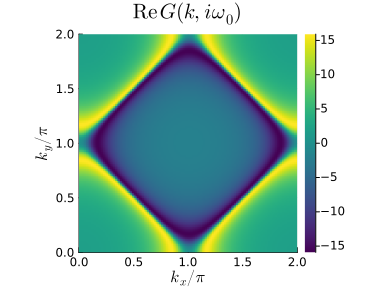

In [54]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

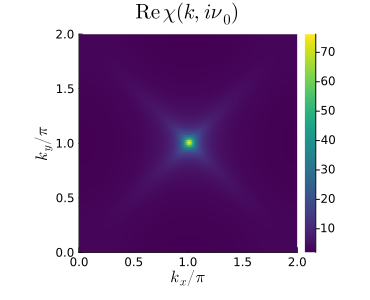

In [55]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [56]:
chi0kf[hnw+1,nsize÷2+1, nsize÷2+1]

4.692079829394033 + 3.333911824022533e-15im

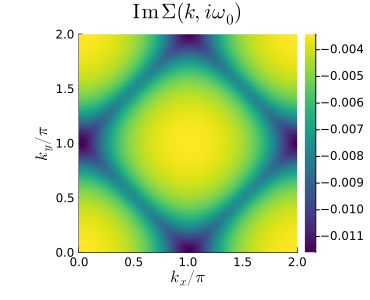

In [57]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, imag.(sekf[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Im}\\,\\Sigma(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [58]:
#smpl_wn_b = SparseIR.default_matsubara_sampling_points(basis.basis_b)
#smpl_wn_b = smpl_wn_b[smpl_wn_b .!= BosonicFreq(0)]
#smpl_wn_b_wo_zero = MatsubaraSampling(basis.basis_b, smpl_wn_b)
;

In [59]:
chisf = chi0kf[:,nsize÷2+1, nsize÷2+1]
#deleteat!(chisf, hnw+1)
#chisl = fit(smpl_wn_b_wo_zero, chisf, dim=1)
#chisf[37] = 0
chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

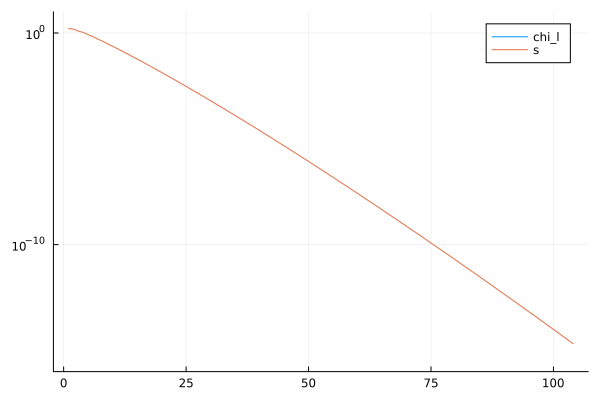

In [60]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

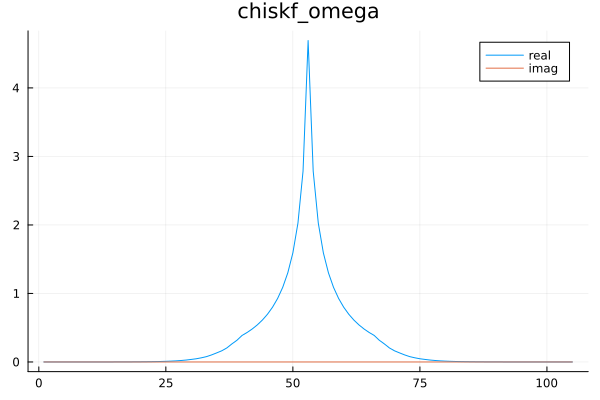

In [61]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

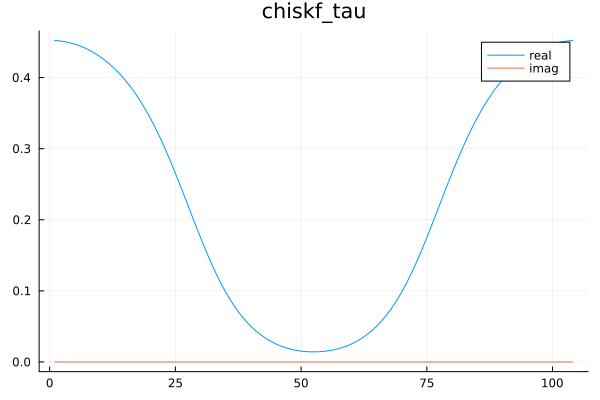

In [62]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [63]:
chisw = evaluate(basis.smpl_wn_f, chisl)
;

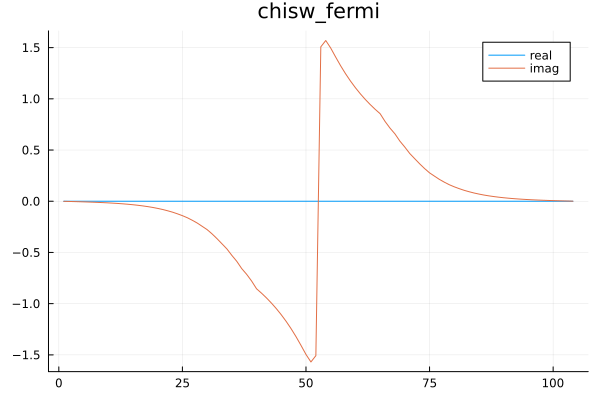

In [64]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [79]:
f = open( "FLEX_chi0.dat", "w")
println(f, "$sum_rule")
for iw in 1:hnw
    omega = imag(SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+iw], SparseIR.β(basis)))
    chi = chisw[hnw+iw]
    println(f, "$omega \t $(real(chi)) \t $(imag(chi))")
end
close(f)
;

In [65]:
sum_rule::Float64 = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl))

0.9044993479645007

In [66]:
setprecision(512)

512

In [67]:
input_chi  = Array{Complex{T}}(undef, hnw) 
input_smpl = Array{Complex{T}}(undef, hnw) 
;

In [68]:
for i in 1:hnw
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(basis))
    input_chi[i]  = -chisw[hnw+i]
end

In [82]:
N_real    =  6000
eta       =  0.001
omega_max =  1.0+eta
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
#1000 → 2000
iter_tol  = 10000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, input_smpl, input_chi)
N_imag = 36
println("N_imag $(N_imag)")

N_imag is setted as 22
N_imag 36


In [83]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, true)
;

Pick matrix is non positive semi-definite matrix in Schur method.
H=1
Iter     Function value   Gradient norm 
     0     2.710431e+00     1.533550e+01
 * time: 0.000202178955078125
     1     2.294481e+00     5.639913e+00
 * time: 4.816163063049316
     2     1.256493e+00     2.826788e+00
 * time: 7.47265100479126
     3     1.121791e+00     5.178773e-01
 * time: 9.536708116531372
     4     1.120466e+00     9.025053e-02
 * time: 10.859414100646973
     5     1.120367e+00     2.453623e-02
 * time: 12.203351974487305
     6     1.120364e+00     6.855561e-03
 * time: 14.187066078186035
     7     1.120364e+00     2.658104e-03
 * time: 16.16742706298828
     8     1.120364e+00     5.486604e-04
 * time: 17.468842029571533
     9     1.120364e+00     3.058730e-04
 * time: 19.4571590423584
    10     1.120364e+00     1.087728e-04
 * time: 20.83138918876648
    11     1.120364e+00     3.450722e-05
 * time: 22.15517807006836
    12     1.120364e+00     8.474265e-06
 * time: 23.493077993392944

In [84]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     1.120364e+00     6.380645e-09
 * time: 0.00020003318786621094
max_theta=0.193684893475676652527249349701480290147060338830454669130119739184156174029624904064978864820228845842392805417773353263047731365302992251376121746599508544
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     1.120364e+00     6.245505e+00
 * time: 0.00020885467529296875
     1     9.855556e-01     5.995866e+00
 * time: 3.7564759254455566
     2     3.308916e-01     1.346905e+00
 * time: 5.982795000076294
     3     3.185498e-01     1.293096e+00
 * time: 8.198463916778564
     4     6.957419e-02     3.734620e-01
 * time: 10.414292812347412
     5     6.566802e-02     1.669204e-01
 * time: 12.619057893753052
     6     6.518393e-02     2.968598e-02
 * time: 14.83213186264038
     7     6.503646e-02     2.569310e-02
 * time: 17.054043769836426
     8     6.503356e-02     1.505854e-03
 * time: 19.2891788482666
     9     6.503

    16     4.989663e-02     6.452280e-04
 * time: 49.23477101325989
    17     4.989622e-02     4.285694e-04
 * time: 52.63552403450012
    18     4.989591e-02     3.815377e-04
 * time: 56.235180139541626
    19     4.989501e-02     1.299948e-03
 * time: 59.672566175460815
    20     4.989209e-02     1.830884e-03
 * time: 63.083954095840454
    21     4.988509e-02     3.562349e-03
 * time: 66.54800796508789
    22     4.985166e-02     4.840386e-03
 * time: 69.94911003112793
    23     4.978180e-02     3.641133e-03
 * time: 73.3858950138092
    24     4.967840e-02     3.102351e-03
 * time: 76.89797401428223
    25     4.967147e-02     5.988429e-04
 * time: 79.12074303627014
    26     4.967049e-02     2.951220e-04
 * time: 81.48583316802979
    27     4.967035e-02     8.054188e-05
 * time: 83.7345700263977
    28     4.967034e-02     1.985519e-05
 * time: 86.09541296958923
    29     4.967034e-02     1.027471e-05
 * time: 89.59488010406494
    30     4.967034e-02     5.934424e-06
 * tim

    67     4.949401e-02     9.145067e-05
 * time: 252.10246992111206
    68     4.949390e-02     1.300731e-04
 * time: 255.99585390090942
    69     4.949373e-02     1.665355e-04
 * time: 260.0810868740082
    70     4.949341e-02     2.273018e-04
 * time: 263.98207092285156
    71     4.949291e-02     2.948886e-04
 * time: 267.869765996933
    72     4.949198e-02     3.862790e-04
 * time: 271.93243503570557
    73     4.949061e-02     5.073234e-04
 * time: 275.8357529640198
    74     4.948825e-02     6.466267e-04
 * time: 279.7441818714142
    75     4.948492e-02     8.346316e-04
 * time: 283.79245495796204
    76     4.947988e-02     1.014868e-03
 * time: 287.6769058704376
    77     4.947288e-02     1.283574e-03
 * time: 291.576189994812
    78     4.946351e-02     1.495793e-03
 * time: 295.49306297302246
    79     4.945089e-02     1.814719e-03
 * time: 299.5444829463959
    80     4.943420e-02     2.024241e-03
 * time: 303.45443296432495
    81     4.941221e-02     2.354169e-03
 *

    74     4.923491e-02     1.183963e-04
 * time: 290.25813484191895
    75     4.923484e-02     1.639577e-04
 * time: 294.56683683395386
    76     4.923478e-02     1.694440e-04
 * time: 297.4565348625183
    77     4.923465e-02     2.412794e-04
 * time: 301.727401971817
    78     4.923454e-02     2.496134e-04
 * time: 304.6561930179596
    79     4.923425e-02     3.533012e-04
 * time: 308.89621782302856
    80     4.923403e-02     3.616596e-04
 * time: 311.7530868053436
    81     4.923345e-02     5.040364e-04
 * time: 315.9996898174286
    82     4.923299e-02     5.152605e-04
 * time: 318.8902928829193
    83     4.923180e-02     7.420235e-04
 * time: 323.15267300605774
    84     4.923088e-02     7.532274e-04
 * time: 326.0708348751068
    85     4.922843e-02     1.046963e-03
 * time: 330.3392629623413
    86     4.922661e-02     1.057230e-03
 * time: 333.2943468093872
    87     4.922177e-02     1.508121e-03
 * time: 337.5923228263855
    88     4.921829e-02     1.517739e-03
 * t

   195     4.882726e-02     7.588414e-05
 * time: 671.5105278491974
   196     4.882725e-02     8.101087e-05
 * time: 674.2945618629456
   197     4.882724e-02     8.911509e-05
 * time: 677.2855248451233
   198     4.882723e-02     9.488757e-05
 * time: 680.040472984314
   199     4.882722e-02     1.046900e-04
 * time: 683.0127220153809
   200     4.882721e-02     1.111895e-04
 * time: 685.9527368545532
   201     4.882719e-02     1.230634e-04
 * time: 690.2023499011993
   202     4.882717e-02     1.303743e-04
 * time: 693.1332628726959
   203     4.882715e-02     1.447808e-04
 * time: 697.3821189403534
   204     4.882713e-02     1.530091e-04
 * time: 700.2520508766174
   205     4.882709e-02     1.705131e-04
 * time: 704.4767138957977
   206     4.882706e-02     1.797769e-04
 * time: 707.3774709701538
   207     4.882702e-02     2.010900e-04
 * time: 711.6105179786682
   208     4.882697e-02     2.115193e-04
 * time: 714.4923429489136
   209     4.882691e-02     2.375449e-04
 * time:

LoadError: InterruptException:

In [85]:
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum_rule, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is non positive semi-definite matrix in Schur method.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

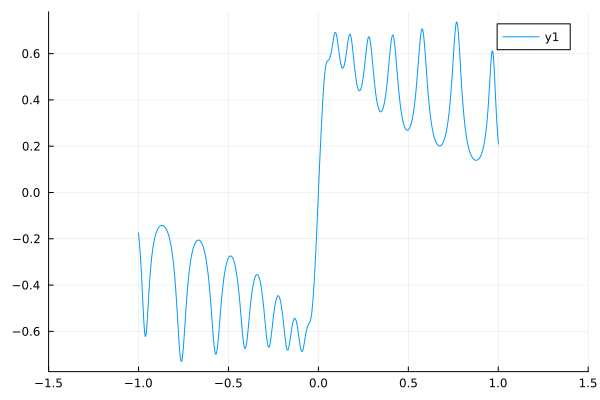

In [86]:
plot(xlim = [-1.5,1.5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
#plot!(real.(sol.reals.freq), imag.(sol.reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))

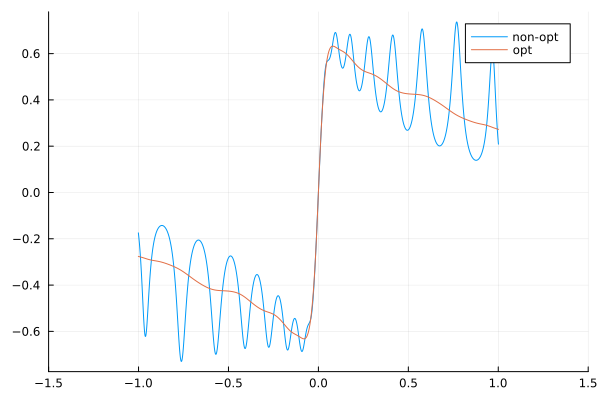

In [87]:
plot(xlim = [-1.5,1.5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt")
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)),label="opt")

In [88]:
plot(xlim = [-1.5,1.5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi),marker=:+)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))

In [33]:
ComplexF64.(raw_reals.freq[1])

-1.001 + 0.001im